<a href="https://colab.research.google.com/github/isra-33/ChineseGP25/blob/main/ChineseGP25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
# Install necessary libraries
!pip install pandas scikit-learn numpy matplotlib seaborn

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor  # Import Random Forest
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
# Create 2025 Chinese GP qualifying data
china_2025_qualifying = pd.DataFrame({
    'Position': range(1, 21),
    'Driver': ['Oscar Piastri', 'George Russell', 'Lando Norris', 'Max Verstappen', 'Lewis Hamilton',
              'Charles Leclerc', 'Isack Hadjar', 'Kimi Antonelli', 'Yuki Tsunoda', 'Alex Albon',
              'Esteban Ocon', 'Nico Hulkenberg', 'Fernando Alonso', 'Lance Stroll', 'Carlos Sainz',
              'Pierre Gasly', 'Oliver Bearman', 'Jack Doohan', 'Gabriel Bortoleto', 'Liam Lawson'],
    'Team': ['McLaren F1 Team', 'Mercedes AMG Petronas F1 Team', 'McLaren F1 Team',
             'Oracle Red Bull Racing', 'Scuderia Ferrari HP', 'Scuderia Ferrari HP',
             'Visa Cash App Racing Bulls F1 Team', 'Mercedes AMG Petronas F1 Team',
             'Visa Cash App Racing Bulls F1 Team', 'Atlassian Williams Racing',
             'MoneyGram Haas F1 Team', 'Stake F1 Team Kick Sauber', 'Aston Martin Aramco F1 Team',
             'Aston Martin Aramco F1 Team', 'Atlassian Williams Racing', 'BWT Alpine F1 Team',
             'MoneyGram Haas F1 Team', 'BWT Alpine F1 Team', 'Stake F1 Team Kick Sauber',
             'Oracle Red Bull Racing'],
    'Q1': ['1m31.591s', '1m31.295s', '1m30.983s', '1m31.424s', '1m31.690s', '1m31.579s',
           '1m31.162s', '1m31.676s', '1m31.238s', '1m31.503s', '1m31.876s', '1m31.921s',
           '1m31.719s', '1m31.923s', '1m31.628s', '1m31.992s', '1m32.018s', '1m32.092s',
           '1m32.141s', '1m32.174s'],
    'Q2': ['1m31.200s', '1m31.307s', '1m30.787s', '1m31.234s', '1m31.501s', '1m31.450s',
           '1m31.253s', '1m31.590s', '1m31.425s', '1m31.595s', '1m31.625s', '1m31.632s',
           '1m31.688s', '1m31.773s', '1m31.840s', None, None, None, None, None],
    'Q3': ['1m30.641s', '1m30.723s', '1m30.793s', '1m30.817s', '1m30.927s', '1m31.021s',
           '1m31.079s', '1m31.103s', '1m31.638s', '1m31.706s', None, None, None, None,
           None, None, None, None, None, None],
    'Track': ['China'] * 20,
    'Year': [2025] * 20
})


In [84]:

# Base URL for GitHub repository for previous data
base_url = "https://raw.githubusercontent.com/toUpperCase78/formula1-datasets/master/"

# Years to include
years = [2024, 2025]

# File names
file_names = {
    2024: {
        "qualifying": "Formula1_2024season_qualifyingResults.csv",
        "race": "Formula1_2024season_raceResults.csv"
    },
    2025: {
        "qualifying": "Formula1_2025Season_QualifyingResults.csv",
        "race": "Formula1_2025Season_RaceResults.csv"
    }
}

# Function to load data
def load_data(year, file_type):
    file_name = file_names.get(year, {}).get(file_type)
    if not file_name:
        return None
    url = f"{base_url}{file_name}"
    try:
        df = pd.read_csv(url)
        df['Year'] = year
        return df
    except Exception as e:
        print(f"Error loading {year} {file_type}: {e}")
        return None

# Load and concatenate data
qualifying_dfs = [china_2025_qualifying]
race_dfs = []

for year in years:
    qual_df = load_data(year, "qualifying")
    race_df = load_data(year, "race")
    if qual_df is not None:
        qualifying_dfs.append(qual_df)
    if race_df is not None:
        race_dfs.append(race_df)

qualifying_data = pd.concat(qualifying_dfs, ignore_index=True)
race_data = pd.concat(race_dfs, ignore_index=True) if race_dfs else pd.DataFrame()

# Merge data
merged_data = pd.merge(
    race_data,
    qualifying_data[['Year', 'Track', 'Driver', 'Team', 'Position', 'Q3']],
    left_on=['Year', 'Track', 'Driver', 'Team'],
    right_on=['Year', 'Track', 'Driver', 'Team'],
    how='left',
    suffixes=('_race', '_qual')
)

merged_data = merged_data.rename(columns={'Position_race': 'Finish_Position', 'Position_qual': 'Qualifying_Position'})

In [85]:
# Handle missing values
merged_data['Q3'] = merged_data['Q3'].fillna('N/A')
non_numeric_values = ['Retired', 'NC', 'DNF', 'DNS', 'DSQ', 'DQ']
merged_data['Finish_Position'] = merged_data['Finish_Position'].replace(non_numeric_values, np.nan)
merged_data = merged_data.dropna(subset=['Finish_Position'])
merged_data['Finish_Position'] = merged_data['Finish_Position'].astype(int)
merged_data['Qualifying_Position'] = pd.to_numeric(merged_data['Qualifying_Position'], errors='coerce').fillna(25)
merged_data['Starting Grid'] = pd.to_numeric(merged_data['Starting Grid'], errors='coerce').fillna(25)

# Encode categorical variables with handling for new labels
le_driver = LabelEncoder()
le_team = LabelEncoder()
le_track = LabelEncoder()

# Fit encoders on all available data (including 2025 qualifying)
all_drivers = pd.concat([merged_data['Driver'], china_2025_qualifying['Driver']]).unique()
all_teams = pd.concat([merged_data['Team'], china_2025_qualifying['Team']]).unique()
all_tracks = pd.concat([merged_data['Track'], china_2025_qualifying['Track']]).unique()

le_driver.fit(all_drivers)
le_team.fit(all_teams)
le_track.fit(all_tracks)

merged_data['Driver_Encoded'] = le_driver.transform(merged_data['Driver'])
merged_data['Team_Encoded'] = le_team.transform(merged_data['Team'])
merged_data['Track_Encoded'] = le_track.transform(merged_data['Track'])

# Feature engineering
driver_avg_finish = merged_data.groupby('Driver_Encoded')['Finish_Position'].mean().to_dict()
team_avg_finish = merged_data.groupby('Team_Encoded')['Finish_Position'].mean().to_dict()
merged_data['Driver_Avg_Finish'] = merged_data['Driver_Encoded'].map(driver_avg_finish)
merged_data['Team_Avg_Finish'] = merged_data['Team_Encoded'].map(team_avg_finish)

# Features and target
features = ['Qualifying_Position', 'Starting Grid', 'Driver_Encoded', 'Team_Encoded',
            'Track_Encoded', 'Driver_Avg_Finish', 'Team_Avg_Finish']
target = 'Finish_Position'

X = merged_data[features]
y = merged_data[target]

In [86]:
# Split and train with Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Use Random Forest
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"MAE: {mae:.2f} positions")
print(f"MSE: {mse:.2f}")

MAE: 2.45 positions
MSE: 10.24


In [87]:
# Predict Chinese GP 2025
chinese_gp_data = china_2025_qualifying.copy()
chinese_gp_data['Track_Encoded'] = le_track.transform(chinese_gp_data['Track'])
chinese_gp_data['Driver_Encoded'] = le_driver.transform(chinese_gp_data['Driver'])
chinese_gp_data['Team_Encoded'] = le_team.transform(chinese_gp_data['Team'])
chinese_gp_data['Qualifying_Position'] = chinese_gp_data['Position']
chinese_gp_data['Starting Grid'] = chinese_gp_data['Position']
chinese_gp_data['Driver_Avg_Finish'] = chinese_gp_data['Driver_Encoded'].map(driver_avg_finish)
chinese_gp_data['Team_Avg_Finish'] = chinese_gp_data['Team_Encoded'].map(team_avg_finish)

# Handle missing average finish values for new drivers/teams
chinese_gp_data['Driver_Avg_Finish'] = chinese_gp_data['Driver_Avg_Finish'].fillna(merged_data['Driver_Avg_Finish'].mean())
chinese_gp_data['Team_Avg_Finish'] = chinese_gp_data['Team_Avg_Finish'].fillna(merged_data['Team_Avg_Finish'].mean())

X_chinese = chinese_gp_data[features]
chinese_predictions = rf_model.predict(X_chinese)

In [88]:
# Results
results = pd.DataFrame({
    'Driver': chinese_gp_data['Driver'],
    'Team': chinese_gp_data['Team'],
    'Predicted_Finish': chinese_predictions
})
results = results.sort_values('Predicted_Finish').reset_index(drop=True)
results['Predicted_Rank'] = results.index + 1

print("\nPredicted Rankings for Chinese GP 2025 (March 23, 2025):")
print(results[['Predicted_Rank', 'Driver', 'Predicted_Finish', 'Team']])


Predicted Rankings for Chinese GP 2025 (March 23, 2025):
    Predicted_Rank             Driver  Predicted_Finish  \
0                1      Oscar Piastri              4.40   
1                2       Lando Norris              4.88   
2                3     George Russell              5.03   
3                4     Max Verstappen              5.09   
4                5     Lewis Hamilton              5.73   
5                6    Charles Leclerc              6.41   
6                7       Isack Hadjar              9.35   
7                8     Kimi Antonelli              9.47   
8                9       Carlos Sainz             10.04   
9               10         Alex Albon             10.08   
10              11       Yuki Tsunoda             10.19   
11              12    Fernando Alonso             11.16   
12              13    Nico Hulkenberg             11.61   
13              14     Oliver Bearman             12.28   
14              15       Esteban Ocon             12.40  

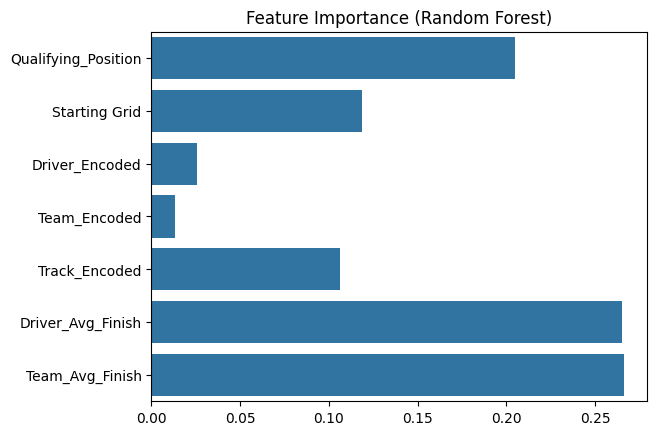

In [89]:
# Feature importance
importances = rf_model.feature_importances_
sns.barplot(x=importances, y=features)
plt.title('Feature Importance (Random Forest)')
plt.show()